# 771948_A23_T3A - Group Work Assignment #
# Part 1 - Numerical and categorical feature classification problem #
## Assignment by Chris Mintz 202369825 and Antonia Agunbiade 202375309 ##

# Task 1 - Load and preprocess the dataset for the classification problem (handle missing data, convert categorical features to numerical features) #

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df = pd.read_excel('dataset1.xlsx')

df.head(20)

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35
5,1,211.72,506.716,Liechtenstein,111.0,310.60,no,2019-03-18 13:00:12
6,0,401.42,627.294,French Guiana,78.0,390.05,no,2019-03-28 02:29:19
7,0,498.90,525.207,Barbados,129.0,408.75,yes,2019-06-07 05:41:16
8,1,257.90,651.209,Netherlands,147.0,280.20,no,2019-02-07 08:02:31
9,1,283.04,467.801,Chad,69.0,272.35,yes,2019-03-26 19:37:46


In [2]:
# have a look at the data types
df.info()

# quick look at the data
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB


,target,var1,var2,var4,var5
count,925.000000,925.000000,925.000000,325.000000,925.000000
mean,0.496216,360.116562,548.390134,108.452308,325.393946
std,0.500256,87.866662,135.221460,26.325744,78.862779
min,0.000000,209.560000,139.965000,57.000000,163.000000
25%,0.000000,278.640000,467.373000,87.000000,257.900000
50%,0.000000,367.640000,569.841000,105.000000,342.350000
75%,1.000000,437.600000,652.278000,126.000000,393.000000
max,1.000000,539.920000,794.848000,180.000000,457.150000


### <font color='yellow'>About this dataset</font> ###
#### var1, var2, var3, var4, var5, var6, var7 columns are features ####
#### var1, var2, var4, var5 are numerical values ####
#### var3, var6 columns are categorical values #### 
#### var 7 is a datetime ####
#### target column is the label ####

### We have null values in the data so lets enumerate them ####

In [3]:
# convert the date to proper datetime. Using coerce because there are errors in the dates
df.isnull().sum()

target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64

In [4]:
# some investigation shows 5 cells with an illegal datetime in them. Specifically, 5 cells have a date of 2019-02-29 which is not a valid date
def fix_not_leap_year(bad_date):
    if '2019-02-29' in str(bad_date):
        bad_date = str(bad_date).replace('2019-02-29', '2019-02-28')
        print(bad_date)
        return bad_date
    else:
        return bad_date

df['var7'] = df['var7'].apply(fix_not_leap_year)


2019-02-28 12:31:57
2019-02-28 18:06:21
2019-02-28 11:00:06
2019-02-28 23:56:06
2019-02-28 19:26:35


In [5]:
# because the the dataset is not a linear regression problem, we'll convert the datetime to features with a custom transformer
# this will allow us to extract the day, month, year and time as separate features.
# define a custom transformer function to extract datetime features
def extract_datetime_features(dates):
    dates = pd.to_datetime(dates, infer_datetime_format=True, errors='coerce')
    return pd.DataFrame({
        'year': dates.dt.year,
        'month': dates.dt.month,
        'day': dates.dt.day,
        'dayofweek': dates.dt.dayofweek,
        'hour': dates.dt.hour
    })

In [6]:
# test the datetime transformer function
date_df = extract_datetime_features(df['var7'])
print(date_df)

     year  month  day  dayofweek  hour
0    2019      7   20          5    13
1    2019      4    4          3    21
2    2019      3    3          6     2
3    2019      3   19          1     8
4    2019      3   18          0    13
..    ...    ...  ...        ...   ...
920  2019      1   22          1    12
921  2019      2    1          4    14
922  2019      6   13          3    18
923  2019      5   27          0     6
924  2019      6   18          1    17

[925 rows x 5 columns]


C:\Users\skyma\AppData\Local\Temp\ipykernel_11116\1019460975.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates = pd.to_datetime(dates, infer_datetime_format=True, errors='coerce')


In [7]:
# DOCS When trying to deal with the datetime, we decided to convert the datetime to numerical features before putting it into the transform/fit process.
# This is because this is not a linear regression problem but a classification problem and we want to extract the day, month, year and time as separate features.
df_combined = pd.concat([df, date_df], axis=1)
print(df_combined)

     target    var1     var2          var3   var4    var5 var6  \
0         0  509.18  417.681    Micronesia  138.0  393.00   no   
1         0  446.06  666.182      Dominica   81.0  352.05  yes   
2         1  235.50  398.097   Isle of Man   90.0  339.00   no   
3         0  306.02  518.163  Turkmenistan  102.0  439.25  yes   
4         0  453.08  600.156      Cameroon  105.0  422.95   no   
..      ...     ...      ...           ...    ...     ...  ...   
920       0  422.34  547.259       Belarus    NaN  350.45  yes   
921       1  342.62  473.919         Japan    NaN  200.85   no   
922       1  265.10  538.170  Saint Martin    NaN  208.35  yes   
923       0  397.12  622.386          Chad    NaN  433.45  yes   
924       1  242.10  420.429       Albania    NaN  369.20  yes   

                    var7  year  month  day  dayofweek  hour  
0    2019-07-20 13:21:37  2019      7   20          5    13  
1    2019-04-04 21:30:46  2019      4    4          3    21  
2    2019-03-03 02:59

In [8]:
# There are too many NA in var4 to simply remove those rows so we will try to impute the missing values #
# We will have to watch the weighting of var4 feature as it will be heavily weighted to the interpolated values #

# TO DO: I don't like the interpolation of the var 4 feature. Hoping to use an algorithm that supports null data or find a regression pattern to better fit OR it's possible this is not used as feature data at all.

# Data normalization #
numerical_features = ['var1', 'var2', 'var4', 'var5', 'year', 'month', 'day', 'dayofweek', 'hour']
categorical_features = ['var3', 'var6']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# the result of this will be a Compressed Sparse Row (CSR) matrix which works with XGBoost and scikit-learn.
df_transformed = preprocessor.fit_transform(df_combined)

# Task 2 - Build a classifier for the classification problem using one of the specified models (logistic regression, decision trees, random forests, or artificial neural networks) #

## <b>References</b>

DataCamp. (2023). Learn XGBoost in Python: A Step-by-Step Tutorial. Available at: https://www.datacamp.com/tutorial/xgboost-in-python [Accessed 19 Aug. 2024].

XGBoost Contributors. (2024). XGBoost Parameters — xgboost 2.1.1 documentation. Available at: https://xgboost.readthedocs.io/en/stable/parameter.html [Accessed 19 Aug. 2024].
##

In [9]:
# going to use XGBoost to train a decision tree model
# we will use the transformed data from the preprocessor as the input data
# target variable is the 'target' column from original df dataset
import xgboost as xgb
from sklearn.model_selection import train_test_split

# setup our features and labels
X = df_transformed
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# We're going to use the DMatrix data structure from XGBoost. This is an optimized data structure that works with XGBoost and is optimized for memory and speed
# Create the regression matrices in DMatrix format
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)


# Now set parameters for XGBoost
params = {
    'objective': 'binary:logistic',  
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'rmse',
    'tree_method': 'hist'
}

# We'll look at the ideal number of rounds in hyperparameter tuning but for now let's use 100 rounds
n = 100
model = xgb.train(
    params, 
    dtrain_reg, 
    n
    )

# Task 3 - Fine tune the selected model using appropriate techniques like hyperparameter tuning, cross-validation, etc.

In [10]:
# let's look at the model's performance and see if any hyperparameter tuning is needed
from sklearn.metrics import root_mean_squared_error

predictions = model.predict(dtest_reg)
# compare the predictions to the actual values
rmse = root_mean_squared_error(y_test, predictions)
print(f'RMSE of the base model: {rmse: .3f}')

RMSE of the base model:  0.208


In [11]:
# looking to improve on the RMSE by using validation sets
# XGBoost has a built-in cross-validation function that we can use to evaluate the model
# using early_stopping_rounds we can stop the training if the model stops improving
cv_results = xgb.cv(
    params,
    dtrain_reg,
    num_boost_round=200,
    seed=0,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.374688        0.001901        0.379958       0.002384
1          0.291967        0.002894        0.307014       0.006842
2          0.234550        0.003283        0.258523       0.011006
3          0.195057        0.004162        0.229269       0.014514
4          0.167249        0.005227        0.208540       0.017469
5          0.148003        0.006094        0.197105       0.018791
6          0.134082        0.006248        0.187272       0.023858
7          0.124377        0.007194        0.183540       0.026014
8          0.116313        0.007408        0.180078       0.027207
9          0.109120        0.007731        0.178278       0.027445
10         0.103634        0.008282        0.176349       0.028497
11         0.098274        0.007286        0.175121       0.028945
12         0.094310        0.007514        0.175397       0.028695
13         0.090890        0.006831        0.174290       0.02

In [12]:
# pull out the best RMSE from the cv_results
best_rmse = cv_results['test-rmse-mean'].min()
print(f'Best tested RMSE: {best_rmse: .3f}')

Best tested RMSE:  0.172


In [13]:
# Now use a hyperparameter grid to test different hyperparameters and effectiveness
from sklearn.model_selection import StratifiedKFold, GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 2, 3, 4, 5],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1]
}

param_model = xgb.XGBRegressor()

param_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(param_model, param_grid, cv=param_cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

# Print the best hyperparameters
print(f'Best learning rate: {grid_search.best_params_["learning_rate"]}')
print(f'Best max depth: {grid_search.best_params_["max_depth"]}')
print(f'Best min child weight: {grid_search.best_params_["min_child_weight"]}')
print(f'Best number of estimators: {grid_search.best_params_["n_estimators"]}')
print(f'Best gamma: {grid_search.best_params_["gamma"]}')
print(f'Best subsample: {grid_search.best_params_["subsample"]}')


Best learning rate: 0.1
Best max depth: 9
Best min child weight: 5
Best number of estimators: 100
Best gamma: 0.1
Best subsample: 0.7


In [14]:
#now apply the new hyperparameters to the re-fit the model
#note, eta = learning rate
params_tuned = {
    'objective': 'binary:logistic',  
    'max_depth': 9,
    'eta': 0.1,
    'gamma': 0.1,
    'subsample': 0.7,
    'min_child_weight': 5,
    'eval_metric': 'rmse',
    'tree_method': 'hist'
}

evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]
evals_result = {}

model = xgb.train(
    params_tuned,
    dtrain_reg,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=10,
    evals_result=evals_result
)

[0]	train-rmse:0.46028	validation-rmse:0.46276
[1]	train-rmse:0.42614	validation-rmse:0.43008
[2]	train-rmse:0.39517	validation-rmse:0.40089
[3]	train-rmse:0.36726	validation-rmse:0.37474
[4]	train-rmse:0.34184	validation-rmse:0.35206
[5]	train-rmse:0.31900	validation-rmse:0.33372
[6]	train-rmse:0.30053	validation-rmse:0.31592
[7]	train-rmse:0.28329	validation-rmse:0.30160
[8]	train-rmse:0.26764	validation-rmse:0.29061
[9]	train-rmse:0.25416	validation-rmse:0.28077
[10]	train-rmse:0.24287	validation-rmse:0.27098
[11]	train-rmse:0.23446	validation-rmse:0.26335
[12]	train-rmse:0.22635	validation-rmse:0.25562
[13]	train-rmse:0.21803	validation-rmse:0.25064
[14]	train-rmse:0.21088	validation-rmse:0.24717
[15]	train-rmse:0.20559	validation-rmse:0.24291
[16]	train-rmse:0.20018	validation-rmse:0.24024
[17]	train-rmse:0.19704	validation-rmse:0.23782
[18]	train-rmse:0.19352	validation-rmse:0.23410
[19]	train-rmse:0.18921	validation-rmse:0.23175
[20]	train-rmse:0.18675	validation-rmse:0.23069
[2

## <b>Observation</b>
The training has early-stopped at less than 200 rounds. It is here that the training loss is low but also takes the slightly fluctuating validation loss into account which we want to watch to ensure we are not getting into overfitting with too many rounds.
##

In [15]:
# try a very high number of rounds to see if we can get a better RMSE for validation
# if overfitting shows up we'll stick with the original model

n_b = 1000

model_b = xgb.train(
    params_tuned, 
    dtrain_reg, 
    n_b, 
    evals=evals, 
    verbose_eval=50
    )

[0]	train-rmse:0.46028	validation-rmse:0.46276
[50]	train-rmse:0.16368	validation-rmse:0.20848
[100]	train-rmse:0.15619	validation-rmse:0.19943
[150]	train-rmse:0.15096	validation-rmse:0.19934
[200]	train-rmse:0.14640	validation-rmse:0.19412
[250]	train-rmse:0.14355	validation-rmse:0.19627
[300]	train-rmse:0.14024	validation-rmse:0.19377
[350]	train-rmse:0.13908	validation-rmse:0.19564
[400]	train-rmse:0.13603	validation-rmse:0.19248
[450]	train-rmse:0.13338	validation-rmse:0.19090
[500]	train-rmse:0.13183	validation-rmse:0.19267
[550]	train-rmse:0.13100	validation-rmse:0.19278
[600]	train-rmse:0.12943	validation-rmse:0.19305
[650]	train-rmse:0.12911	validation-rmse:0.19159
[700]	train-rmse:0.12520	validation-rmse:0.19087
[750]	train-rmse:0.12398	validation-rmse:0.19007
[800]	train-rmse:0.12239	validation-rmse:0.19191
[850]	train-rmse:0.12057	validation-rmse:0.19120
[900]	train-rmse:0.11896	validation-rmse:0.19356
[950]	train-rmse:0.11809	validation-rmse:0.19150
[999]	train-rmse:0.1160

## <b>Observation</b>
Interesting attempt to improve the model but as was shown in early-stop, there is little validation loss improvement even by the time the model reaches 50 rounds. model_b will be discarded in favour of the originally trained model.
##

# Task 4 - Visualise the dataset and the model's results, where applicable like feature importance, confusion matrix, etc

## <b>References</b>

C. Simon. (Dec 2022). Your first XGBoost Model in Python - easy to follow tutorial. Available at: https://medium.com/@Machine_Learning_tut/your-first-xgboost-model-in-python-easy-to-follow-tutorial-17c4e0075850 [Accessed Aug 12, 2024]
##



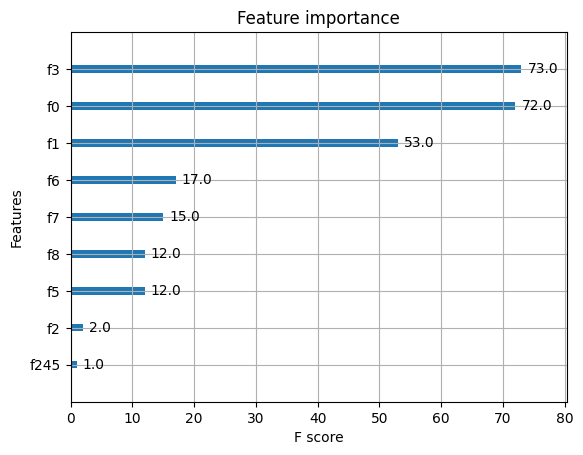

In [16]:
# do a quick look into feature importance using XGBoost's built-in feature importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

In [17]:
# look at the feature scores
scores = model.get_score(importance_type='gain')

# print out all the scores
for feature, score in scores.items():
    print(f'{feature}: {score}')

f0: 33.0942268371582
f1: 2.4128408432006836
f2: 2.1330740451812744
f3: 11.896151542663574
f5: 1.2405434846878052
f6: 1.6053705215454102
f7: 1.7770607471466064
f8: 1.2422958612442017
f245: 2.8632020950317383


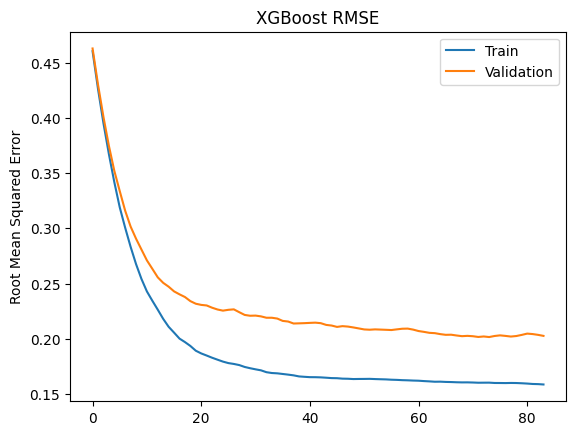

In [18]:
# do a plot of the training and validation error
# these were defined earlier during model training and have been sitting in the evals_result dictionary
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['rmse'], label='Train')
ax.plot(x_axis, evals_result['validation']['rmse'], label='Validation')
ax.legend()
plt.ylabel('Root Mean Squared Error')
plt.title('XGBoost RMSE')
plt.show()

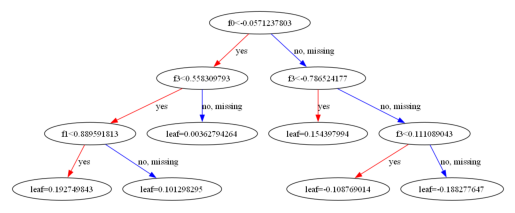

In [19]:
# Visualize individual trees in the trained XGBoost model
xgb.plot_tree(model, num_trees=0)
plt.show()

In [20]:
# look at the confusion matrix
predictions = model.predict(dtest_reg)
predictions = [round(value) for value in predictions]
confusion = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
print(confusion)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy * 100: .3f}%')

Confusion Matrix:
[[97  5]
 [ 6 77]]
Accuracy:  94.054%


# Task 5 - Report the final performance of the selected model using the appropriate performance metrics like accuracy, F1-score, etc

In [21]:
# look at the accuracy and f1 score
print(classification_report(y_test, model.predict(dtest_reg) > 0.5, digits=3))

              precision    recall  f1-score   support

           0      0.942     0.951     0.946       102
           1      0.939     0.928     0.933        83

    accuracy                          0.941       185
   macro avg      0.940     0.939     0.940       185
weighted avg      0.941     0.941     0.941       185



# Commit the final model to file 

In [22]:
import pickle
with open('final-assignment-part-1-model.pkl', 'wb') as f:
    pickle.dump(model, f)